In [1]:
import pyvista as pv
from Kirchhoffpy import lenspy
from Kirchhoffpy import Feedpy
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from Kirchhoffpy import coordinate,field_storage
from Kirchhoffpy.Vopy import CO,dotproduct,abs_v
c=299792458
mu=4*np.pi*10**(-7);
epsilon=8.854187817*10**(-12);
Z0=np.sqrt(mu/epsilon,dtype = np.float64)
p = pv.Plotter()
srffolder = 'srf/'

In [2]:
# 1. define frequnecy and wavelength
freq = 90*10**9
Lambda = c*1000/freq
k = 2*np.pi/Lambda
print(Lambda,k)

3.3310273111111113 1.8862605197565134


In [3]:
# 2. define coordinate systems
coord_ref = coordinate.coord_sys([0,0,0],[0,0,0],axes = 'xyz')

coord_L1 = coordinate.coord_sys([0,0,-(844.621988-4.34990822154231*10)],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)

coord_feed = coordinate.coord_sys([0,0,0],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)

coord_sky = coordinate.coord_sys([0,0,0],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)

In [4]:
# 3. define input Feedhorn
feed= Feedpy.GaussiBeam(-8,8,
                        k,
                        coord_feed,
                        polarization = 'x')

7.787540624053921e+80


In [5]:
# 4. Lenses and aperture 
L1 = lenspy.simple_Lens(3.36,
                        4.34990822154231*10,# Thickness
                        44.3704085511817*10, # diameter
                        srffolder + 'lens1_f2.rsf', 
                        srffolder + 'lens1_f1.rsf',
                        p,
                        coord_L1,
                        name = 'L1',
                        outputfolder = 'output/')
#L2 = lenspy.simple_Lens(2,46.9671 ,400, srffolder + 'lens2_f1.rsf', srffolder + 'lens2_f2.rsf',p,[0,0,-227.64396727901004],name = 'L2')
#L3 = lenspy.simple_Lens(2,29.6556 ,400, srffolder + 'lens3_f1.rsf', srffolder + 'lens3_f2.rsf',p,[0,0,-71.77590111674095],name = 'L3')

In [6]:
# 5. fiedl storage
center_grd = field_storage.Spherical_grd(coord_sky,
                                         0,
                                         0,
                                         20,
                                         20,
                                         501,501,
                                         Type = 'ELoverAz', 
                                         far_near = 'far',
                                         distance = 50000)


In [7]:
"""
N1 =[380,1360]
N2 = [380,380]
L1.PO_analysis(#[400,1,400,1],
               [1,N1[0],N1[1],1],
               [1,N2[0],N2[1],1],
               #[5,N2[0],N2[1],1],
            feed,k,
            sampling_type_f1='polar',
            phi_type_f1 = 'less',
            sampling_type_f2='polar',
            phi_type_f2 = 'less',
            po_name = '_po_cur_0mm_x.h5',
            Method ='POPO')
"""

"\nN1 =[380,1360]\nN2 = [380,380]\nL1.PO_analysis(#[400,1,400,1],\n               [1,N1[0],N1[1],1],\n               [1,N2[0],N2[1],1],\n               #[5,N2[0],N2[1],1],\n            feed,k,\n            sampling_type_f1='polar',\n            phi_type_f1 = 'less',\n            sampling_type_f2='polar',\n            phi_type_f2 = 'less',\n            po_name = '_po_cur_0mm_x.h5',\n            Method ='POPO')\n"

In [8]:
center_grd.grid.x = center_grd.grid.x.ravel()
center_grd.grid.y = center_grd.grid.y.ravel()
center_grd.grid.z = center_grd.grid.z.ravel()
print(center_grd.grid.z.size)

251001


In [9]:
L1.surf_cur_file = 'output/L1_po_cur_0mm_x.h5'

L1.source(center_grd,
          k,
          far_near = 'far')

cores: 626


100%|█████████████████████████████████████████| 400/400 [00:37<00:00, 10.58it/s]


In [10]:
r, theta, phi = center_grd.coord_sys._toSpherical(center_grd.grid.x,center_grd.grid.y,center_grd.grid.z)
co,cx,crho = CO(theta,phi)
E_co = dotproduct(center_grd.E,co)
E_cx = dotproduct(center_grd.E,cx)

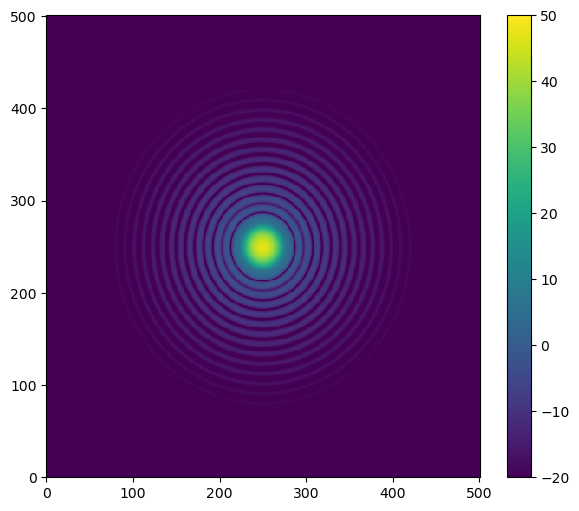

In [11]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(E_co.reshape(501,-1)))*20,vmax = 50, vmin = -20)
plt.colorbar()

In [12]:
import h5py as h5
def readh5(fname):
    name = fname.split('.')
    with h5.File(name[0]+'.h5','r') as f:
        co = f['co-polar'][:,:]
        cx = f['cx-polar'][:,:]
        Az = f['Az'][:]
        El = f['El'][:]
    return Az, El, co, cx

In [13]:
Az, El, grasp_co,grasp_cx = readh5('output/_H5/Lens1_POPO_nostop_GaussianBeam_force_farGHz.h5')

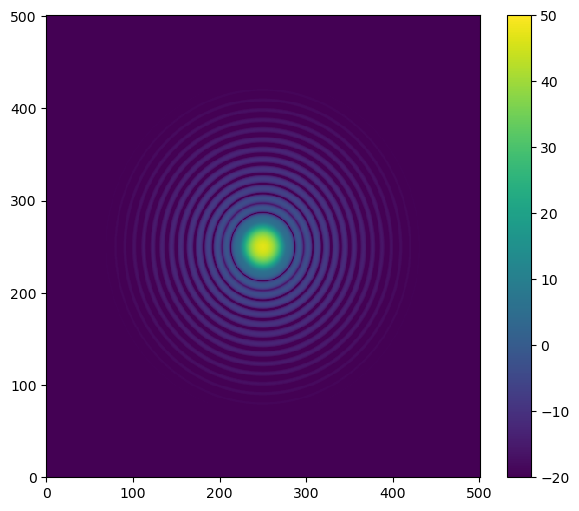

In [14]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(grasp_co.reshape(501,-1)))*20,vmax = 50, vmin = -20)
plt.colorbar()

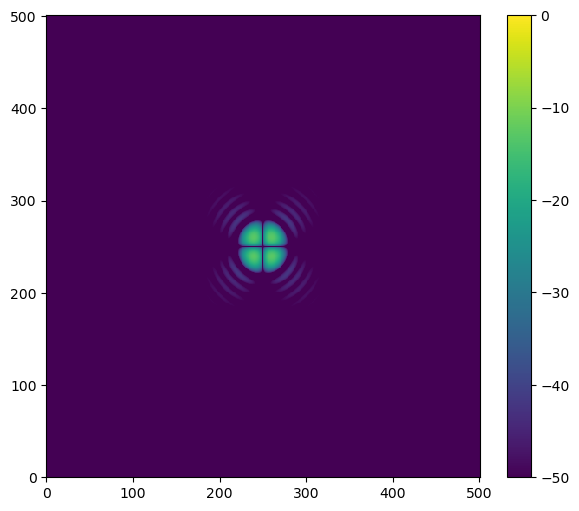

In [15]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(grasp_cx.reshape(501,-1)))*20,vmax = 0, vmin = -50)
plt.colorbar()

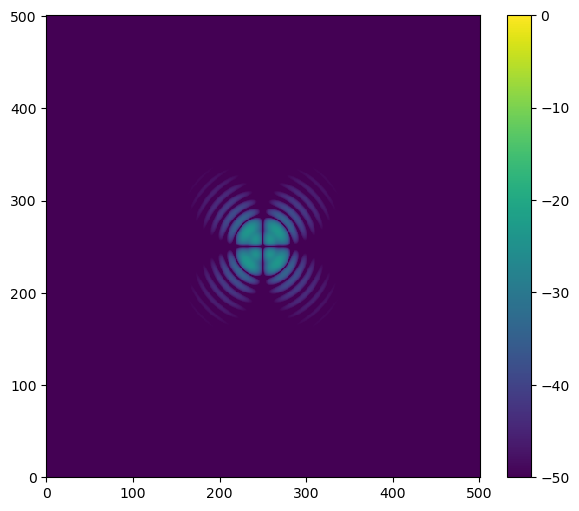

In [16]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(E_cx.reshape(501,-1).T)**2)*10,vmax = 0, vmin = -50)
plt.colorbar()

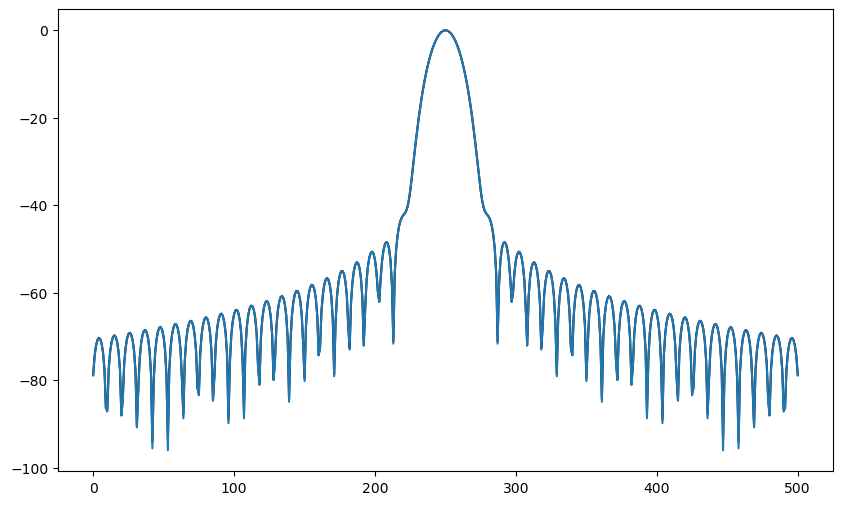

In [17]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:])/np.abs(grasp_co.reshape(501,-1)[250,:]).max())*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])/np.abs(E_co.reshape(501,-1)[250,:]).max())*20,'-')

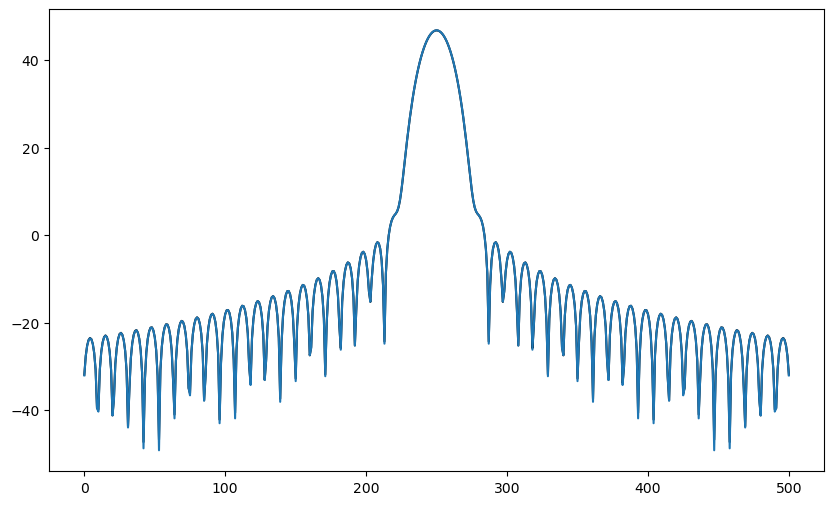

In [18]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')

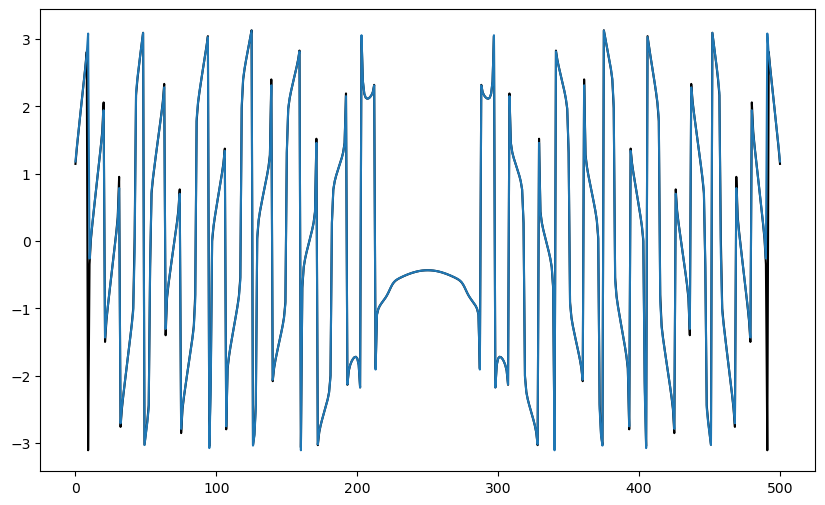

In [19]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.angle(grasp_co.reshape(501,-1)[250,:]/np.abs(grasp_co.reshape(501,-1)[250,:]).max()),'k-')
plt.plot(np.angle(E_co.reshape(501,-1)[250,:]/np.abs(E_co.reshape(501,-1)[250,:]).max()),'-')

In [20]:
ratio = np.abs(E_co.reshape(501,-1)[250,:]).max()*np.sqrt(4*np.pi/Z0)/k/np.abs(grasp_co.reshape(501,-1)[250,:]).max()
print(ratio)

0.0970764225967781


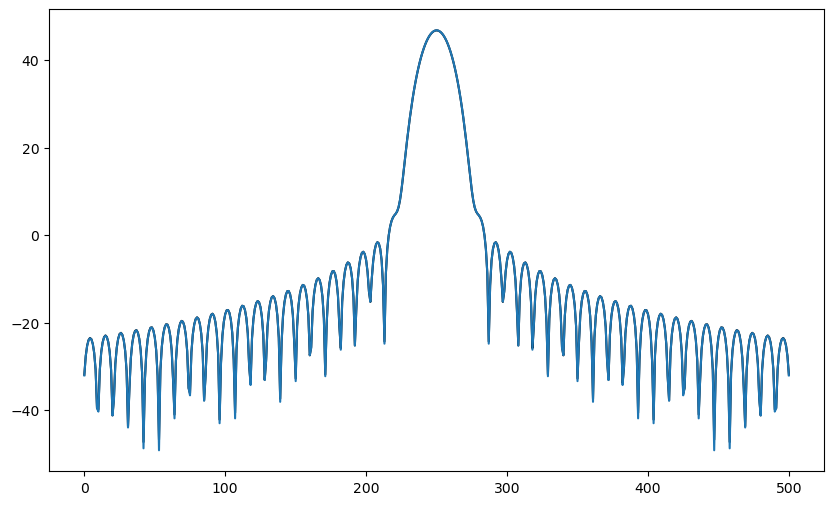

In [21]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')

In [22]:
G_co = grasp_co.reshape(501,-1).T/grasp_co.reshape(501,-1)[250,250]
H_co = E_co.reshape(501,-1).T/E_co.reshape(501,-1)[250,250]
err = G_co-H_co

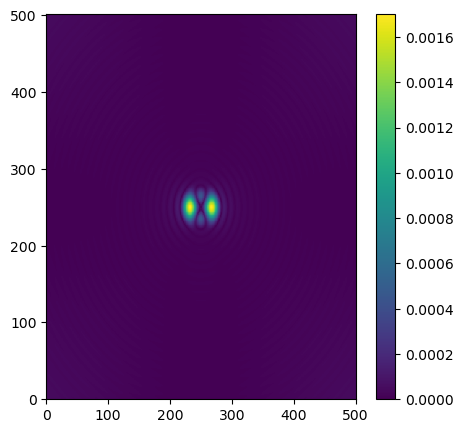

In [23]:
fig = plt.figure(figsize=(5,5))
plt.pcolor(np.abs(err))
plt.colorbar()

In [24]:
G_co = grasp_co.reshape(501,-1)/grasp_co.reshape(501,-1)[250,250]
H_co = E_co.reshape(501,-1)/E_co.reshape(501,-1)[250,250]
err = G_co-G_co.T
err2 = H_co-H_co.T

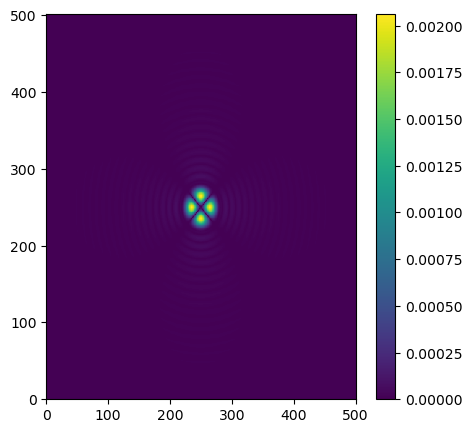

In [25]:
fig = plt.figure(figsize=(5,5))
plt.pcolor(np.abs(err))
plt.colorbar()

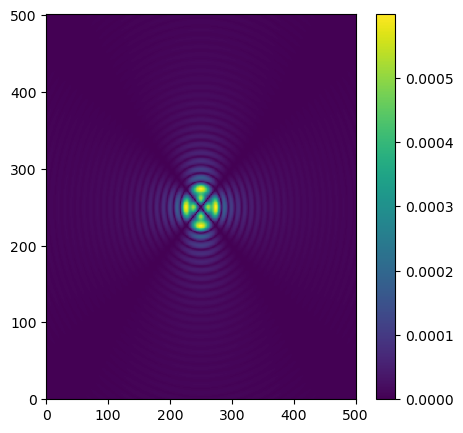

In [26]:
fig = plt.figure(figsize=(5,5))
plt.pcolor(np.abs(err2))
plt.colorbar()

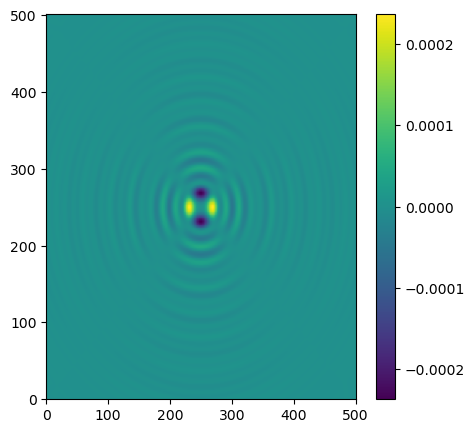

In [27]:
fig = plt.figure(figsize=(5,5))
plt.pcolor(err.imag)
plt.colorbar()

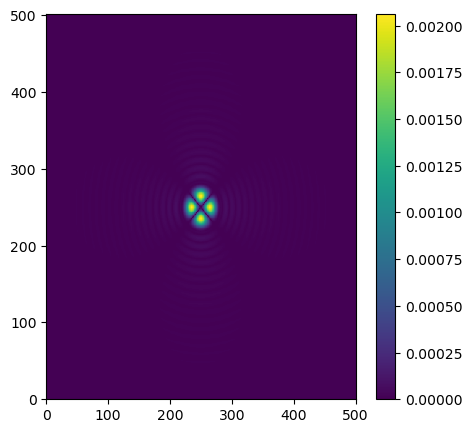

In [28]:
fig = plt.figure(figsize=(5,5))
plt.pcolor(np.abs(err))
plt.colorbar()

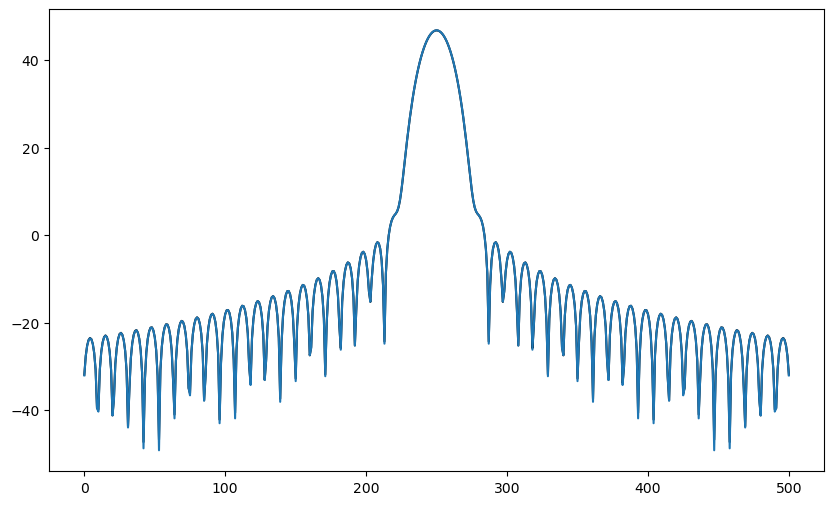

In [29]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')

(-60.0, -10.0)

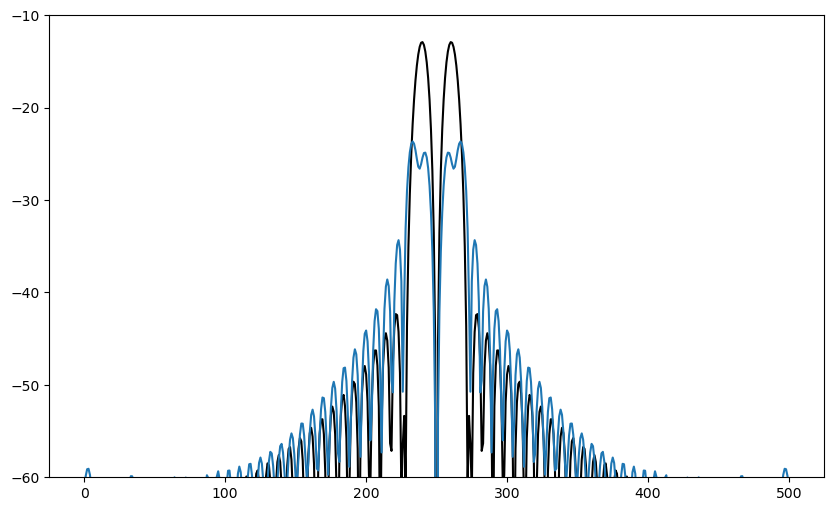

In [30]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(np.diagonal(grasp_cx.reshape(501,-1))))*20,'k-')
plt.plot(np.log10(np.abs(np.diagonal(center_grd.E.y.reshape(501,-1))))*20,'-')
plt.ylim([-60,-10])